<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist, instant_firing_rate, correlation
from human_hip.animate import animate_latencies
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

from scipy.ndimage import gaussian_filter
from scipy.signal import correlate, correlation_lags

In [2]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

# Try IFR

### Initial Curation

In [3]:
def cross_correlation_max_shift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]


In [4]:
cross_sttc_min_cutoff=2
cross_sttc_max_cutoff=30
sttc_cutoff = 0.04
latency_cutoff=2.5
sttc_delta=20 

In [5]:
# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")


18496 Starting Pairs


567 pairs above sttc cutoff


In [6]:
# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
    if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
    #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
        #pairs_late.append( pair )  #lags_late.append( latency )
        if np.mean(pair_latencies) < 0:
            pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
            if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                #print("original pair: ", pair)
                #print("added pair: ", [ pair[1], pair[0] ])
                pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
        else:
            pairs_late.append( pair ) 
#pairs_late
print( len(pairs_late), "pairs above latencency cutoff")

107 pairs above latencency cutoff


### Functions

In [59]:
def compute_lag_times(ifr1, ifr2, mode):
    len1 = len(ifr1)
    len2 = len(ifr2)
    
    if mode == 'full':
        lags = np.arange(-(len2-1), len1)
    elif mode == 'valid':
        lags = np.arange(-(len2-1), len1-len2+1)
    elif mode == 'same':
        mid = len2 // 2
        lags = np.arange(-mid, mid+1)
    else:
        raise ValueError("Mode should be 'full', 'valid', or 'same'")
    
    return lags


### Calculate ifr from pair

In [30]:
#pair = pairs_late[10]
pair = [123,9]

In [31]:
ifr1 = instant_firing_rate(sd, pair[0], max_ifr=.1 )
ifr2 = instant_firing_rate(sd, pair[1], max_ifr=.1 )

In [60]:
cross_corr = np.correlate( ifr1, ifr2, mode='same')
lags = compute_lag_times(ifr1, ifr2,"same")

In [61]:
lags[np.argmax(cross_corr)]

722

In [62]:
lags

array([-191805, -191804, -191803, ...,  191803,  191804,  191805])

In [39]:
print(len(ifr1))
print(len(ifr2))
print(len(ifr2)-len(ifr1))

382149
383611
1462


In [32]:
cross_corr = np.correlate( ifr1, ifr2, mode='full')


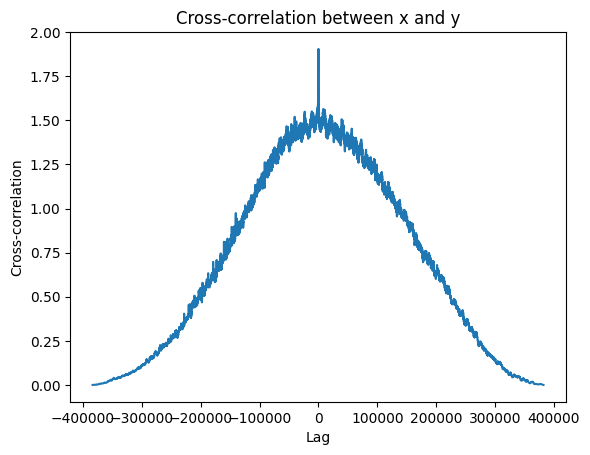

In [58]:
lags1 = compute_lag_times(ifr1, ifr2,"full")


# Plot the cross-correlation
plt.plot( lags1, cross_corr)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between x and y')

plt.show()

In [34]:
cross_corr2 = np.correlate( ifr1, ifr2, mode='valid')

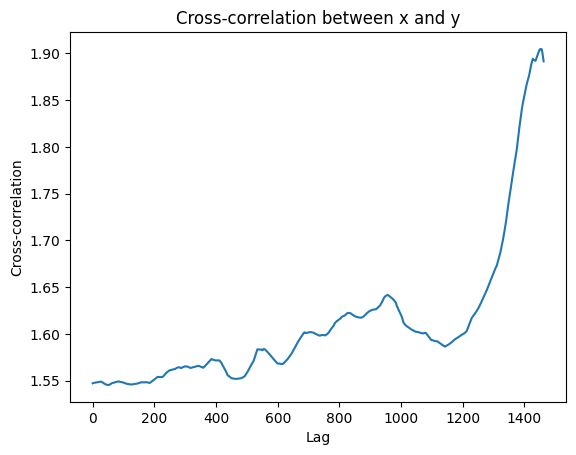

In [55]:
lags2 = compute_lag_times(ifr1, ifr2,"valid")

# Plot the cross-correlation
plt.plot( cross_corr2)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between x and y')

plt.show()

In [36]:
cross_corr3 = np.correlate( ifr1, ifr2, mode='same')

In [40]:
len(cross_corr3)

383611

Text(0.5, 1.0, 'Cross-correlation between x and y')

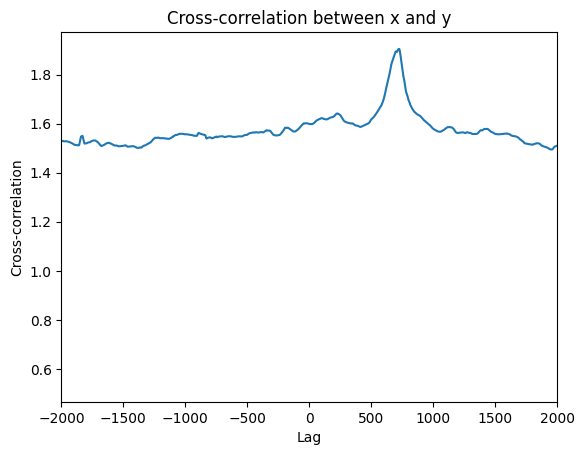

In [63]:

lags3 = compute_lag_times(ifr1, ifr2,"same")


# Plot the cross-correlation
plt.plot( lags3, cross_corr3)
plt.xlim(-2000,2000)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between x and y')

In [47]:
print( 382149 * 2 )
print( 383611 * 2 )

764298
767222


In [46]:
len(cross_corr)

765759

In [49]:
compute_lag_times(ifr1, ifr2,"full")

array([-383610, -383609, -383608, ...,  382146,  382147,  382148])

In [50]:
compute_lag_times(ifr1, ifr2,"valid")

array([-383610, -383609, -383608, ...,   -1464,   -1463,   -1462])

In [51]:
compute_lag_times(ifr1, ifr2,"same")

array([-191805, -191804, -191803, ...,  191803,  191804,  191805])

In [48]:
def compute_lag_times(ifr1, ifr2, mode):
    len1 = len(ifr1)
    len2 = len(ifr2)
    
    if mode == 'full':
        lags = np.arange(-(len2-1), len1)
    elif mode == 'valid':
        lags = np.arange(-(len2-1), len1-len2+1)
    elif mode == 'same':
        mid = len2 // 2
        lags = np.arange(-mid, mid+1)
    else:
        raise ValueError("Mode should be 'full', 'valid', or 'same'")
    
    return lags


In [59]:

correlation

<function human_hip.spike_data.analysis.correlation(x, y)>

In [58]:
ifr11 == ifr1

True

[0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.013888888888888888,
 0.01388888

### <font color="brown"> Old Stuff

In [31]:
pair = pairs_late[0]

ifr1 = instant_firing_rate(sd, pair[0], max_ifr=.1 )
ifr2 = instant_firing_rate(sd, pair[1], max_ifr=.1 )
# ifr1 = gaussian_filter( instant_firing_rate(sd, pair[0], max_ifr=.1 ), 20)
# ifr2 = gaussian_filter( instant_firing_rate(sd, pair[1], max_ifr=.1 ), 20)


In [33]:
len(ifr1)

375006

In [34]:
len(ifr2)

384771

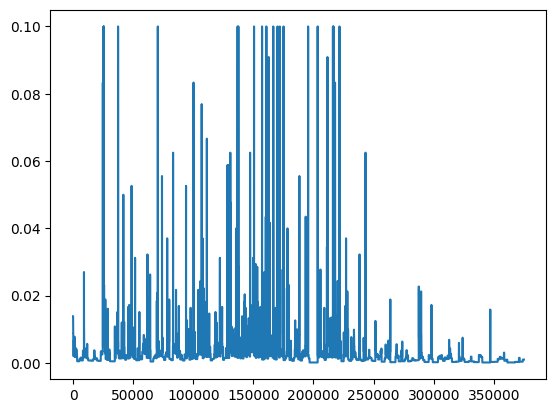

In [21]:
plt.plot(ifr1 )
#plt.xlim(20000,40000)

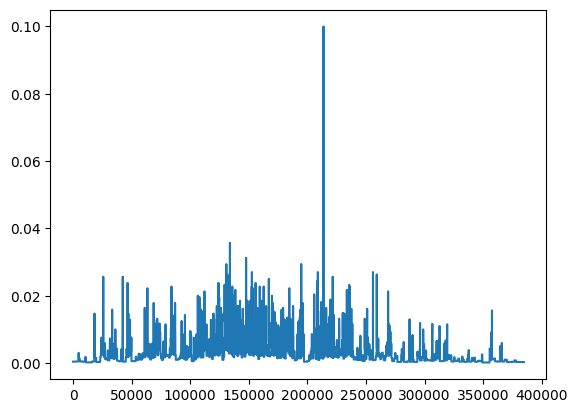

In [22]:
plt.plot(ifr2)

In [32]:
x=ifr1
y=ifr2

cross_corr = np.correlate(x, y, mode='full')

# Create a time lag array
lags = np.arange(-len(x) + 1, len(x))



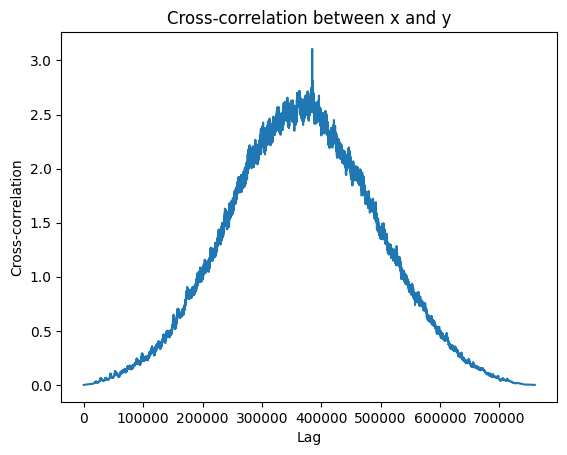

In [27]:
# Plot the cross-correlation
plt.plot( cross_corr)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between x and y')

plt.show()

In [35]:
pair

[6, 0]

In [38]:
spike_times1 = np.unique( np.round(sd.train[6]).astype(int) )
spike_times2 = np.unique( np.round(sd.train[0]).astype(int) )

In [39]:
spike_times1[-1]

375006

In [40]:
spike_times2[-1]

384771

In [41]:
len(ifr1)

375006

In [42]:
len(ifr2)

384771

In [47]:
#spike_times2+1

# <font color="red"> Fail

In [ ]:
def instant_firing_rate(sd, spike_times, max_ifr=9e10 ):
    """
    Function: Calculates instant firing rate for a single neuron (the inverse of the ISI)
    Inputs:
        sd: SpikeData object
        neuron_num (int): index of neuron to calculate instant firing rate of
        max_ifr (int): maximum possible value of instant firing rate. Stops the rate from being too high
    Outputs:
        instant_fire_rate (list):  list of the instant firing rate at every ms in time
    """
    #spike_times= np.unique( np.round(sd.train[neuron_num]).astype(int) )  # get spike times, round to nearest ms, remove duplicates
    instant_fire_rate = []
    last_spike = 0
    for spike_time in spike_times:          # for every spike
        isi = spike_time-last_spike         # calculate time in between spikes  
        instant_fire_rate+= [max_ifr]*isi if 1/isi>max_ifr else [1/isi]*isi   # calculate instant firing rate, add to list
        last_spike = spike_time             # update last spike time
    return instant_fire_rate

In [ ]:
train1 = np.unique( np.round( sd.train[pair[0]] ).astype(int) )
train2 = np.unique( np.round(sd.train[pair[1]]).astype(int)  )
ifr2 = instant_firing_rate(sd, train2, max_ifr=.1 )
cross_ifr = []

for i in range(-1000,1001):
    train1_new = train1 + i
    ifr1 = instant_firing_rate(sd, train1_new, max_ifr=.1 )
    cross_ifr.append( correlation(ifr1, ifr2) )

cross_ifr = np.array(cross_ifr)


# <font color="brown">Old Stuff

In [3]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    #print("original pair: ", pair)
                    #print("added pair: ", [ pair[1], pair[0] ])
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 
    pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # print("Checking all latencies are positive")
    # mean_latencies = []
    # for pair in pairs_late:
    #     mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
    #     mean_latencies.append(mean_latency)
    # print("All positvie?: ",np.all( np.array(mean_latencies)>0 ) )

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs_late: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")

    pairs_final = []
    for i in to_keep:
        pairs_final.append(pairs_late[i])

    
    mean_latencies = []
    for pair in pairs_final:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_final



In [4]:
#good_pairs = curate_latencies(sd)
good_pairs = curate_latencies(sd)
#good_pairs = np.array(good_pairs)
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
# load pickled data
# with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)

18496 Starting Pairs
567 pairs above sttc cutoff
107 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
70 pairs between cross_sttc cutoffs
all final pairs positive?: True


In [5]:
good_pairs2 = np.array(good_pairs)

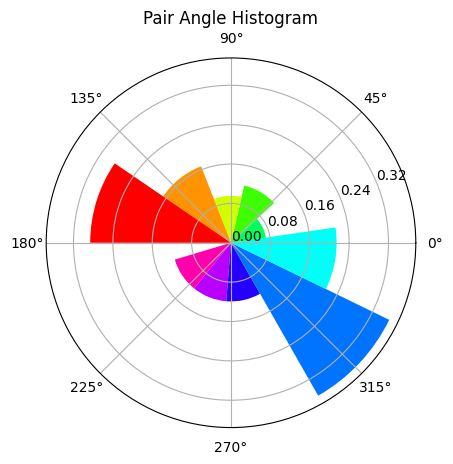

In [6]:
plot_latency_angle_hist(sd, good_pairs2)

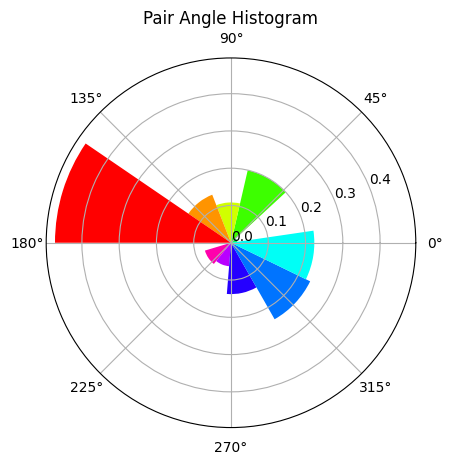

In [7]:
plot_latency_angle_hist(sd, good_pairs2, by_firing_rate=True, late_cutoff_high=30 )

# Vector plots

In [9]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

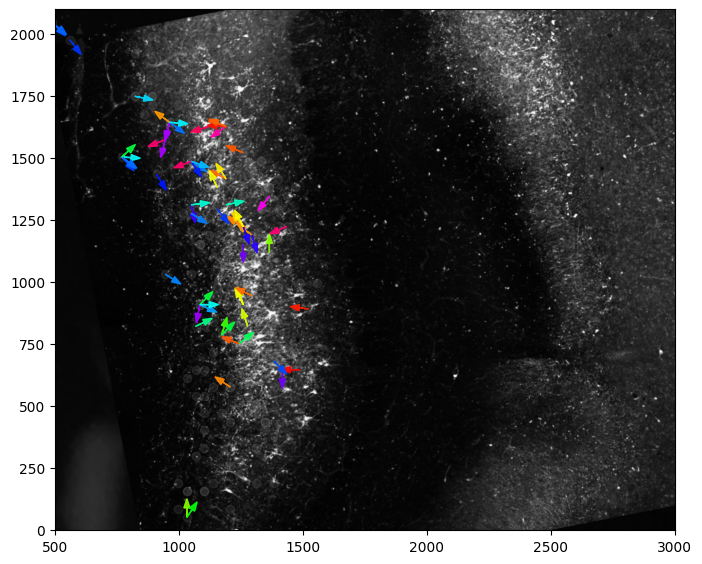

In [10]:
plot_vector_layout( sd, good_pairs2, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

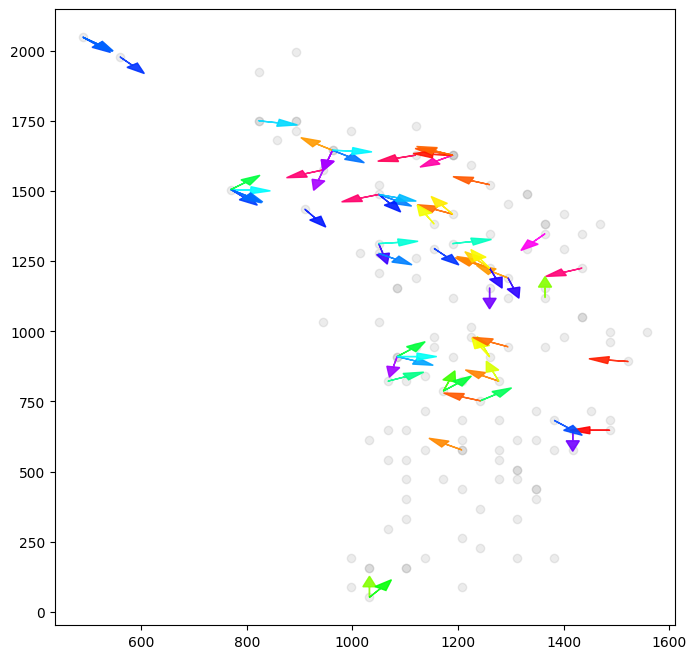

In [11]:
plot_vector_layout( sd, good_pairs2)

In [8]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs2, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs2, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=34, description='pair_i', max=69), Output()), _dom_classes=('widget-inte…